In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [25]:
## Number of Samples
NO_OF_SAMPLES = 100
LENGTH_OF_SAMPLE = 1000

## width of the wave
T = 20


In [26]:
x = np.empty((NO_OF_SAMPLES, LENGTH_OF_SAMPLE), np.float32)
x[:] = np.array(range(LENGTH_OF_SAMPLE)) + np.random.randint(-4*T, 4*T, NO_OF_SAMPLES).reshape(NO_OF_SAMPLES,1)

In [27]:
y = np.sin(x/1.0/T).astype(np.float32)

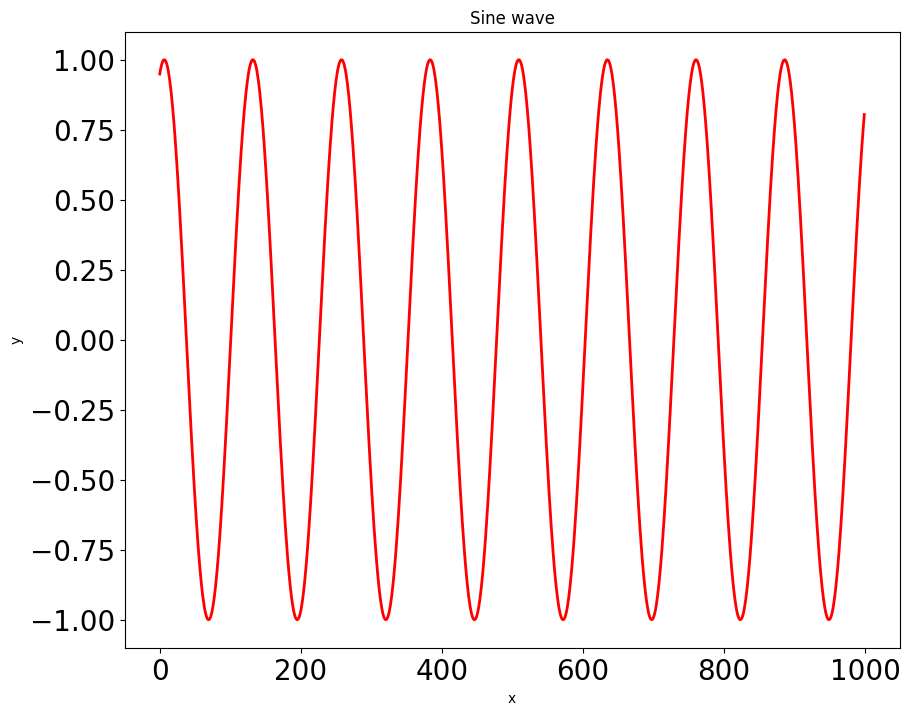

In [28]:
plt.figure(figsize=(10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], "r", linewidth = 2.0)
plt.show()

In [29]:
## For next 1000 values, we want to predict them

## Let's create a class for it

In [30]:
class LSTMPredictor(nn.Module):
    def __init__(self,n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        
        #LSTM 1, LSTM 2, Linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        
        ## Stack 2 LSTM together
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        
        self.linear = nn.Linear(self.n_hidden, 1)
        
    def forward(self,x,future = 0):
        outputs = []
        n_samples = x.size(0)
        
        ## initial hidden state LSMT1
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        ## initial cell state LSTM1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        
        ## initial hidden state LSMT2
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        ## initial cell state LSTM2
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1, dim = 1):
            
            
            h_t, c_t = self.lstm1(input_t, (h_t,c_t))
            
            h_t2, c_t2 = self.lstm2(h_t, (h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t,c_t))
            
            h_t2, c_t2 = self.lstm2(h_t, (h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs
            
        

In [32]:
if __name__ == "__main__":
    
    ## y shape = 100, 1000
    train_input = torch.from_numpy(y[3:, :-1]) ## 97, 999
    
    train_target = torch.from_numpy(y[3:, 1:])  ## 97, 999
    
    test_input = torch.from_numpy(y[:3, :-1])  ## 3, 999
    
    test_target = torch.from_numpy(y[:3, 1:])  ## 3, 999
    
    model = LSTMPredictor()
    criterion = nn.MSELoss()
    ## Learning Rate 
    lr = 0.8
    optimizer = optim.LBFGS(model.parameters(), lr)
    
    ## 10 for training, use more for better prediction
    n_steps = 10
    
    for i in range(n_steps):
        
        print("Step ",i)
        
        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            
            loss = criterion(out, train_target)
            
            print("loss ", loss.item())
            
            loss.backward()
            
            return loss

        
        ## Training is done
        optimizer.step(closure)
        
        
        ## Turn all gradients to False for prediction, less memory taken
        with torch.no_grad():
            future = 1000
            pred = model(test_input, future= future)
            loss = criterion (pred[:,:-future], test_target)
            print("test loss ", loss.item())
            y = pred.detach().numpy()
            
            
        

Step  0
loss  0.496371865272522
loss  0.4924730956554413
loss  0.46221792697906494
loss  0.40393194556236267
loss  0.6515069007873535
loss  0.2394694983959198
loss  0.11044033616781235
loss  0.766061007976532
loss  0.021072031930088997
loss  0.0204994548112154
loss  0.019840680062770844
loss  0.018949201330542564
loss  0.017055129632353783
loss  0.014051225036382675
loss  0.00978403352200985
loss  0.008578908629715443
loss  0.004050721414387226
loss  0.003331333864480257
loss  0.00180322106461972
loss  0.02571634203195572
test loss  0.0015973297413438559
Step  1
loss  0.0015193935250863433
loss  0.0010838255984708667
loss  0.0010124512482434511
loss  0.0009884930914267898
loss  0.0009244781103916466
loss  0.0008931935299187899
loss  0.0008331058197654784
loss  0.0007557747885584831
loss  0.0006766514852643013
loss  0.0006170261767692864
loss  0.0005739277112297714
loss  0.000546933792065829
loss  0.0005337758339010179
loss  0.0005117742693983018


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,6))
plt.title(f"Step {i+1}")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

n= train_input.shape[1]
def draw(y_i,color):
    plt.plot(np.arange(n), y_i[:n], color, linewidth = 2.0)
    plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth = 2.0)

draw(y[0],'r')
draw(y[1],'b')
draw(y[2],'g')

plt.savefig("predict%d.pdf"%i)

plt.close()

